# Recommender Systems with Surprise
- **Created by Andrés Segura Tinoco**
- **Created on May 24, 2019**
- **Updated on Jul 22, 2020**

## Experiment description
- Model built from a Pandas dataframe
- The algorithm used is: Singular Value Decomposition (SVD)
- Model trained using train and test datasets (80/20)
- The error of the model was estimated using the RMSE metric
- Type of filtering: collaborative

In [1]:
# Load the Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load Surprise libraries
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

In [3]:
# Load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Loading data

In [4]:
# Path to dataset file
file_path = os.path.expanduser('../data/u.data')

# Read current ratings of the users
data = pd.read_csv(file_path, sep = '\t', names = ['user_id','item_id','rating','timestamp'])
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
# Path to dataset file
file_path = os.path.expanduser('../data/u.item')

# Read items dataframe
items = pd.read_csv(file_path, sep = '|', header = None, usecols = [0, 1, 2], encoding = 'ISO-8859-1')
items.columns = ['item_id', 'item_name', 'item_date']
items.head()

,item_id,item_name,item_date
0,1,Toy Story (1995),01-Jan-1995
1,2,GoldenEye (1995),01-Jan-1995
2,3,Four Rooms (1995),01-Jan-1995
3,4,Get Shorty (1995),01-Jan-1995
4,5,Copycat (1995),01-Jan-1995


## 2. Data description

In [6]:
# Merge data (user-item rating) with item (item description) dataframes
data_item = pd.merge(data, items, on = 'item_id') 
data_item.head()

,user_id,item_id,rating,timestamp,item_name,item_date
0,196,242,3,881250949,Kolya (1996),24-Jan-1997
1,63,242,3,875747190,Kolya (1996),24-Jan-1997
2,226,242,5,883888671,Kolya (1996),24-Jan-1997
3,154,242,3,879138235,Kolya (1996),24-Jan-1997
4,306,242,5,876503793,Kolya (1996),24-Jan-1997


In [7]:
# Create dataframe with 'rating' and 'count' values 
ratings = pd.DataFrame(data_item.groupby('item_name')['rating'].mean())  
ratings['count'] = pd.DataFrame(data_item.groupby('item_name')['rating'].count()) 
ratings.head()

,rating,count
item_name,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


In [8]:
# Sorting values according to the num of rating column
ratings.sort_values('count', ascending = False).head(10)

,rating,count
item_name,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


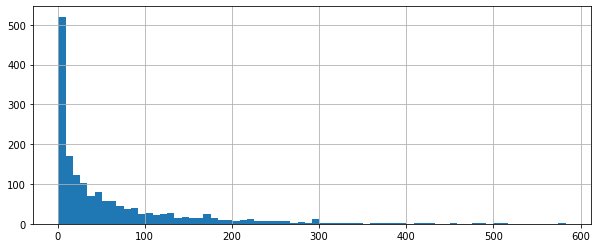

In [9]:
# Plot graph of 'count' column
plt.figure(figsize = (10, 4))
ratings['count'].hist(bins = 70)
plt.show()

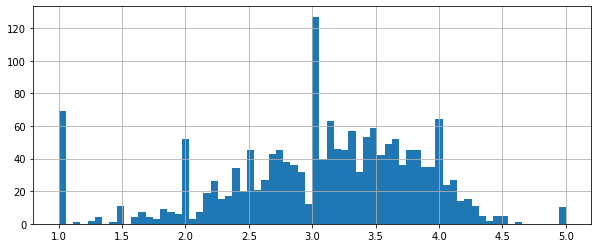

In [10]:
# Plot graph of 'ratings' column
plt.figure(figsize = (10, 4))
ratings['rating'].hist(bins = 70)
plt.show()

## 3. Split data: training and testing datasets

In [11]:
# Split data in training and test
train_data, test_data = train_test_split(data, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)      # 20.00%

Train size: (80000, 4)
Test size: (20000, 4)


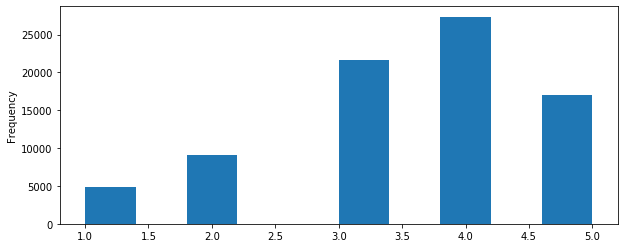

In [12]:
# Plot a ratings histogram of training data
plt.figure(figsize = (10, 4))
train_data.rating.plot.hist(bins = 10)
plt.show()

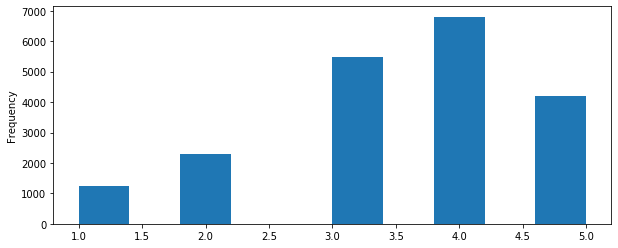

In [13]:
# Plot a ratings histogram of training data
plt.figure(figsize = (10, 4))
test_data.rating.plot.hist(bins = 10)
plt.show()

**Note:** The two histograms look similar. Both datasets have a similar distribution of the rating variable.

In [14]:
# Read the data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
data_test = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

In [15]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [16]:
mean = data_train.global_mean
print('Train rating', mean)

Train rating 3.531475


In [17]:
mean = data_test.global_mean
print('Test rating', mean)

Test rating 3.5234


In [18]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

## 4. Train the model and measure its error

**Use the famous <a href="https://surprise.readthedocs.io/en/stable/matrix_factorization.html" target="_blank">SVD</a> algorithm, as popularized by Simon Funk during the Netflix Prize**

In [19]:
# Create SVD algorithm with 5 factors
k_factors = 5
algo = SVD(n_factors= k_factors, n_epochs= 200, biased= True, lr_all= 0.005, reg_all= 0, init_mean= 0, init_std_dev= 0.01)

In [20]:
# Train the algorithm on the trainset
algo.fit(data_train)

In [21]:
# Calculate RMSE for training dataset
train_pred = algo.test(data_trainset)
accuracy.rmse(train_pred)

RMSE: 0.7492


0.7491527179513694

In [22]:
# Calculate RMSE for test dataset
test_pred = algo.test(data_testset)
accuracy.rmse(test_pred)

RMSE: 0.9524


0.9524248395052974

## 5. Make some predictions

In [23]:
# Show first 5 rows
train_data.head(5)

,user_id,item_id,rating,timestamp
29052,514,11,4,875318082
90711,748,79,4,879454998
47619,504,53,4,887911730
87706,868,161,2,877107056
26007,366,561,5,888858078


In [24]:
# Prediction without real rating
p1 = algo.predict(uid = train_data.iloc[0].user_id, iid = train_data.iloc[0].item_id, verbose = True)

user: 514        item: 11         r_ui = None   est = 3.90   {'was_impossible': False}


In [25]:
# Prediction with real rating
p2 = algo.predict(uid = 196, iid = 302, r_ui = 4, verbose = True)

user: 196        item: 302        r_ui = 4.00   est = 4.17   {'was_impossible': False}


## 6. Analyze SVD matrices

### 6.1. Original Matrix

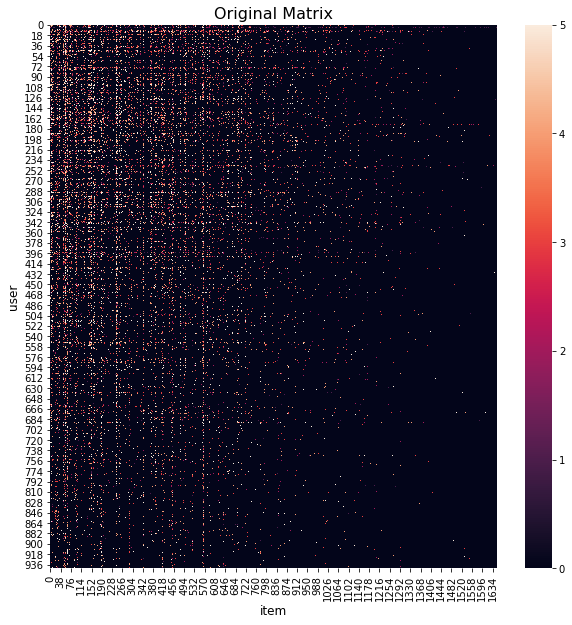

In [26]:
# Reconstruction of original matrix
original = np.zeros((data_train.n_users, data_train.n_items))
for (u, i, r) in data_train.all_ratings():
    original[u][i] = r

# Plot matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(original, ax=ax)
ax.set_title("Original Matrix", fontsize = 16)
ax.set_xlabel('item', fontsize = 12)
ax.set_ylabel('user', fontsize = 12)
plt.show()

### 6.2. Prediction Matrix

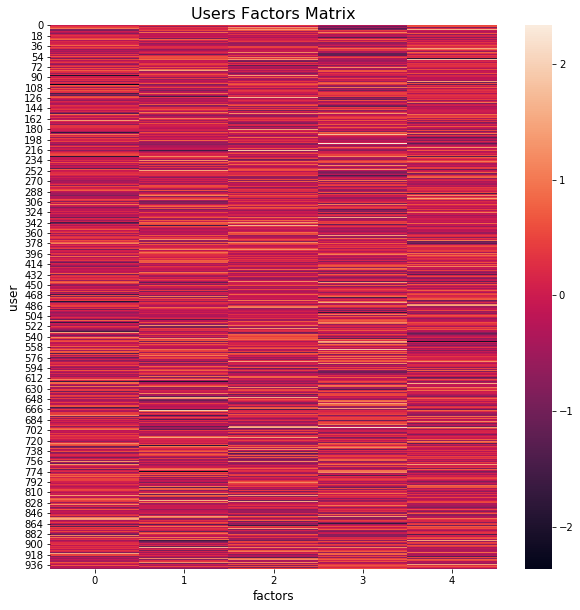

In [27]:
# Users factors matrix with 5 factors
pu = algo.pu

# Plot users factors
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pu, ax=ax)
ax.set_title("Users Factors Matrix", fontsize = 16)
ax.set_xlabel('factors', fontsize = 12)
ax.set_ylabel('user', fontsize = 12)
plt.show()

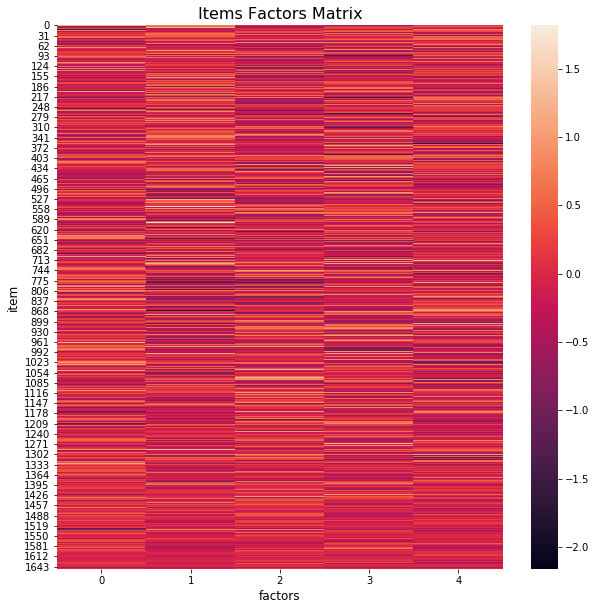

In [28]:
# Items factors matrix with 5 factors
qi = algo.qi

# Plot items factors
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(qi, ax=ax)
ax.set_title("Items Factors Matrix", fontsize = 16)
ax.set_xlabel('factors', fontsize = 12)
ax.set_ylabel('item', fontsize = 12)
plt.show()

You can also view the bias of users $b_u$ and items $b_i$

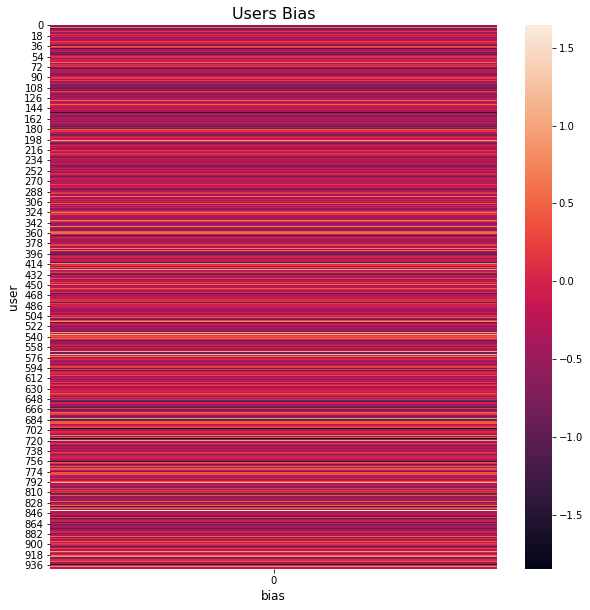

In [29]:
# Users bias
bu = algo.bu.reshape(algo.bu.shape[0], 1)

# Plot bias
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(bu, ax=ax)
ax.set_title("Users Bias", fontsize = 16)
ax.set_xlabel('bias', fontsize = 12)
ax.set_ylabel('user', fontsize = 12)
plt.show()

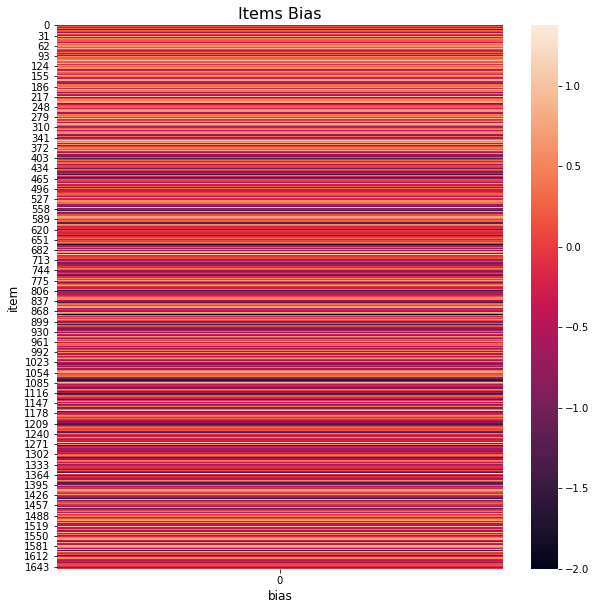

In [30]:
# Items bias
bi = algo.bi.reshape(algo.bi.shape[0], 1)

# Plot bias
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(bi, ax=ax)
ax.set_title("Items Bias", fontsize = 16)
ax.set_xlabel('bias', fontsize = 12)
ax.set_ylabel('item', fontsize = 12)
plt.show()

**Reconstruction of Prediction matrix**
$$ \hat{r}_{ui} = \mu + b_{u} + b_{i} + p_{u} \dot q_{i}^{T} \tag{1} $$

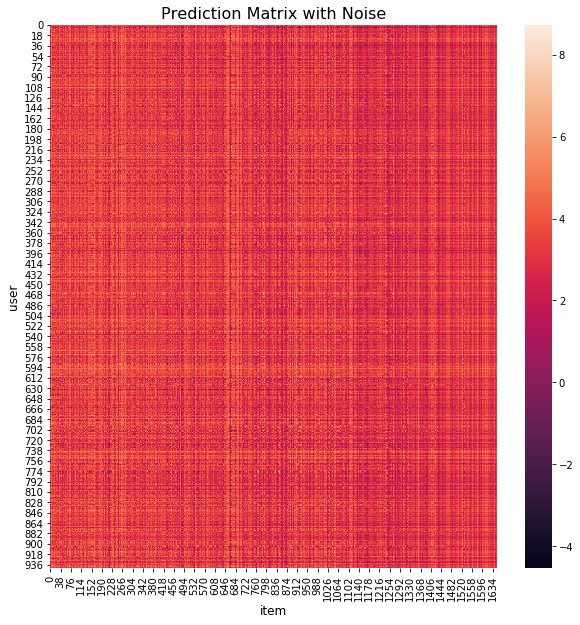

In [31]:
# Reconstruction of original matrix
mean = data_train.global_mean
reconstruct = mean + bu + bi.T + (pu).dot((qi).T)

# Plot matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(reconstruct, ax=ax)
ax.set_title("Prediction Matrix with Noise", fontsize = 16)
ax.set_xlabel('item', fontsize = 12)
ax.set_ylabel('user', fontsize = 12)
plt.show()

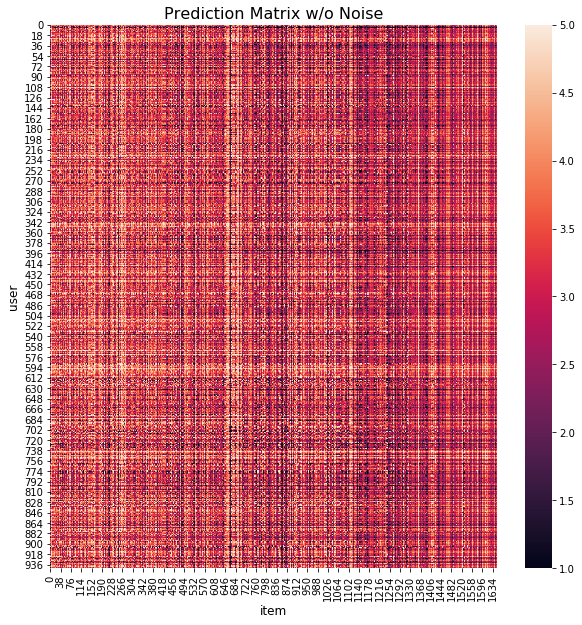

In [32]:
# The predictions are adjusted, since there are values less than 1 and greater than 5
reconstruct = np.clip(reconstruct, 1, 5)

# Plot matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(reconstruct, ax=ax)
ax.set_title("Prediction Matrix w/o Noise", fontsize = 16)
ax.set_xlabel('item', fontsize = 12)
ax.set_ylabel('user', fontsize = 12)
plt.show()

### 6.3. Comparison: Original vs Prediction

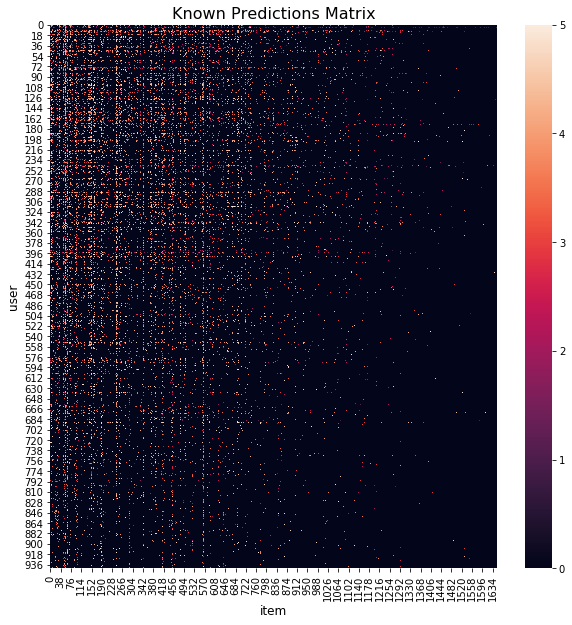

In [33]:
# Get known predictions
known_entries = (original == 0)
reconstruct[known_entries] = 0

# Plot matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(reconstruct, ax=ax)
ax.set_title("Known Predictions Matrix", fontsize = 16)
ax.set_xlabel('item', fontsize = 12)
ax.set_ylabel('user', fontsize = 12)
plt.show()

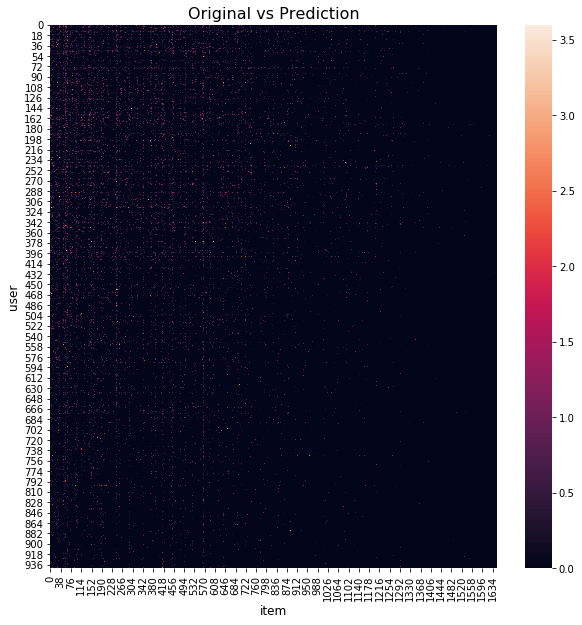

In [34]:
# Get diff matrix
diff_matrix = np.abs(original - reconstruct)

# Plot diff matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(diff_matrix, ax=ax)
ax.set_title("Original vs Prediction", fontsize = 16)
ax.set_xlabel('item', fontsize = 12)
ax.set_ylabel('user', fontsize = 12)
plt.show()

**Average Absolute Difference** between Original ratings and Prediction ratings.

In [35]:
diff_matrix.sum() / len(train_data)

0.5817283332538663

## 7. Conclusions

- The SVD algorithm (or its SVD++ variant) is a very good option to characterize giant data matrices and create recommender systems, using few k factors in which it condenses the information of users and items.
- This allows that, once the model is created the recommendations are fast, even if the model has taken a long time to be generated.

---
<a href="https://ansegura7.github.io/RS_Surprise/">&laquo; Home</a>